# Feature Selection

In [126]:
import pandas as pd

df = pd.read_csv('./data/transaction_dataset.csv')
df

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,9836,2175,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork
9837,9837,2176,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
9838,9838,2177,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,2189.29,261601.88,67,43,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com
9839,9839,2178,0xffde23396d57e10abf58bd929bb1e856c7718218,1,0.00,0.00,0.00,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
# حذف ستون های بی معنی

df = df.drop(columns=['Unnamed: 0', 'Index', 'Address', ' ERC20 most sent token type', ' ERC20_most_rec_token_type',' ERC20 uniq sent addr.1', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract'], errors='ignore')

In [128]:
# شناسایی ستون‌های غیر عددی

categorical_columns = df.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_columns.tolist())

Categorical columns: []


In [129]:
#   اصلاح داده های ناقص
# بررسی مقدار های گمشده

missing = df.isnull().sum()

# حذف یا جایگزینی مقادیر گمشده(مثلا با میانگین) 

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df.select_dtypes(include='number')),
                     columns=df.select_dtypes(include='number').columns)

In [130]:
# جدا کردن فیچر ها و لیبل ها

x = df_imputed.drop(columns=['FLAG'])   #ّ Features
y = df_imputed['FLAG']                  # Lables

In [131]:
# تقسیم داده برای آموزش و تست

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=112, stratify=y)

In [132]:
# Feature Selection => Random Forest Algorithm (Suitable for large and nonlinear data)

from sklearn.ensemble import RandomForestClassifier

rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(x_train, y_train)

importances = rf_selector.feature_importances_
feature_names = x_train.columns

# انتخاب 20 ویژگی برتر
import numpy as np

top_n = 20
indices = np.argsort(importances)[::-1][:top_n]
selected_features = feature_names[indices]       # selected_features => لیستی از 20 ویزگی برتر

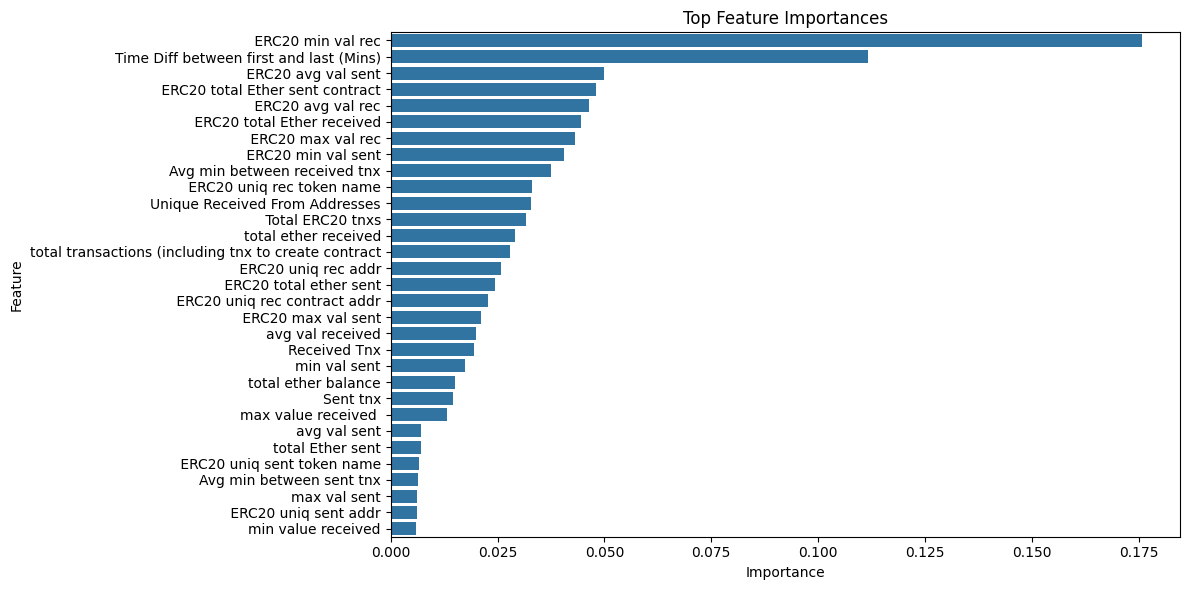

In [133]:
# نمودار اهمیت ویژگی ها

import pandas as pd

feature_importance = pd.DataFrame({
    'Feature': x.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance[feature_importance['Importance'] >= 0.005])
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()

In [134]:
# فقط همون ویژگی‌های مهم رو از دیتای آموزش و تست نگه می‌داریم

x_train_selected = x_train[selected_features]
x_test_selected = x_test[selected_features]

In [135]:
# ذخیره دیتای تمیز با ویژگی‌های انتخاب‌ شده

x_selected = x[selected_features]
x_selected['FLAG'] = y
x_selected.to_csv('./data/cleaned_selected_features.csv', index=False)


C:\Users\aDMIN\AppData\Local\Temp\ipykernel_13220\1142769943.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_selected['FLAG'] = y


# Balnced data

In [136]:
import numpy as np
import pandas as pd

df = pd.read_csv('./data/cleaned_selected_features.csv')
df['FLAG'].value_counts()

FLAG
0.0    7662
1.0    2179
Name: count, dtype: int64

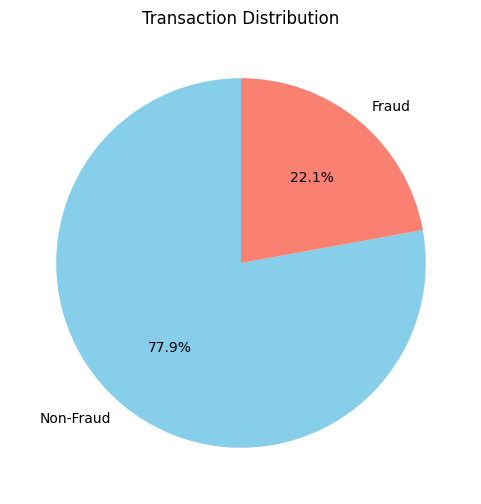

In [137]:
# Pie Chart
import matplotlib.pyplot as plt

labels = ['Non-Fraud', 'Fraud']
sizes = y.value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title("Transaction Distribution")
plt.show()

In [138]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

smote = SMOTE(random_state=112)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train_selected, y_train)

print("Before SMOTE: ", x_train.shape, y_train.value_counts().to_dict())
print("After SMOTE: ", x_train_balanced.shape, y_train_balanced.value_counts().to_dict())

import numpy as np

#  افزودن نویز گوسین به داده آموزش
noise_factor = 0.05 
x_train_noisy = x_train_balanced.copy()
x_train_noisy += noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_balanced.shape)


Before SMOTE:  (7872, 39) {0.0: 6129, 1.0: 1743}
After SMOTE:  (12258, 20) {1.0: 6129, 0.0: 6129}


c:\Users\aDMIN\Desktop\FraudDetection\machine_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


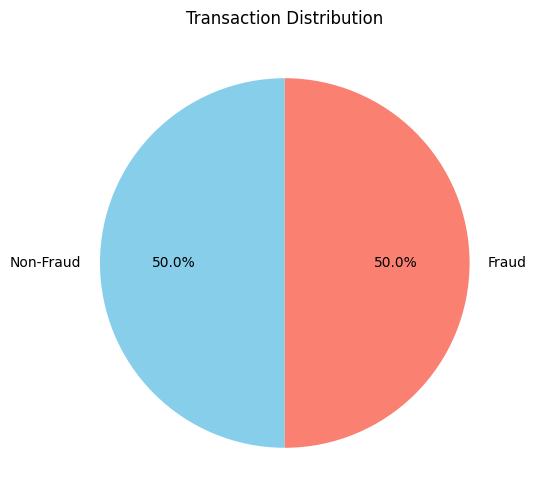

In [139]:
# Pie Chart 

import matplotlib.pyplot as plt

labels = ['Non-Fraud', 'Fraud']
sizes = y_train_balanced.value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title("Transaction Distribution")
plt.show()

# Standardization

In [140]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_noisy)
x_test_scaled = scaler.transform(x_test_selected)
x_scaled = scaler.fit_transform(x)

# KNN

In [141]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_scaled, y_train_balanced)

KNeighborsClassifier()

In [142]:
y_pred_knn = knn.predict(x_test_scaled)

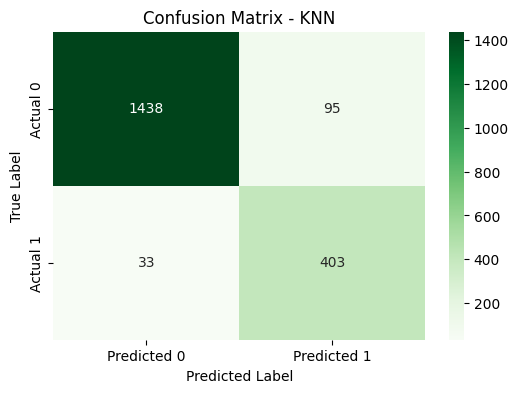

Accuracy: 0.93
Recall: 0.92
Precision: 0.81


In [143]:
# Accuracy, Recall, Precision, Confusion_Matrix

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# محاسبه ماتریس درهم‌ریختگی
cm_knn = confusion_matrix(y_test, y_pred_knn)

# ترسیم ماتریس درهم‌ریختگی
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KNN')
plt.show()

# محاسبه دقت، بازخوانی و دقت کلاس مثبت
acc_knn = accuracy_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)

# نمایش مقادیر
print(f"Accuracy: {acc_knn:.2f}")
print(f"Recall: {recall_knn:.2f}")
print(f"Precision: {precision_knn:.2f}")


In [144]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, x_scaled, y, cv=5)

print("CV Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())

CV Accuracy Scores: [0.95073641 0.95630081 0.95985772 0.95528455 0.95934959]
Mean Accuracy: 0.9563058194700789
Standard Deviation: 0.003284565915372291


# RF

In [145]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, random_state=112 )
rf.fit(x_train_scaled, y_train_balanced)

RandomForestClassifier(n_estimators=10, random_state=112)

In [146]:
y_pred_rf = rf.predict(x_test_scaled)

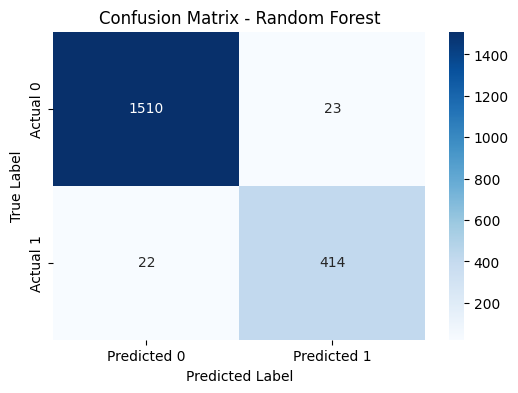

Accuracy: 0.98
Recall: 0.95
Precision: 0.95


In [147]:
# Accuracy, Recall, Precision, Confusion_Matrix

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# محاسبه ماتریس درهم‌ریختگی
cm = confusion_matrix(y_test, y_pred_rf)

# ترسیم ماتریس درهم‌ریختگی
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# محاسبه دقت، بازخوانی و دقت مثبت
acc_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)

# نمایش مقادیر
print(f"Accuracy: {acc_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")
print(f"Precision: {precision_rf:.2f}")

In [148]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, x_scaled, y, cv=5)

print("CV Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation:", scores.std())

CV Accuracy Scores: [0.9781615  0.9796748  0.98018293 0.9796748  0.97611789]
Mean Accuracy: 0.9787623819610467
Standard Deviation: 0.001485756528863693


# Conclusion


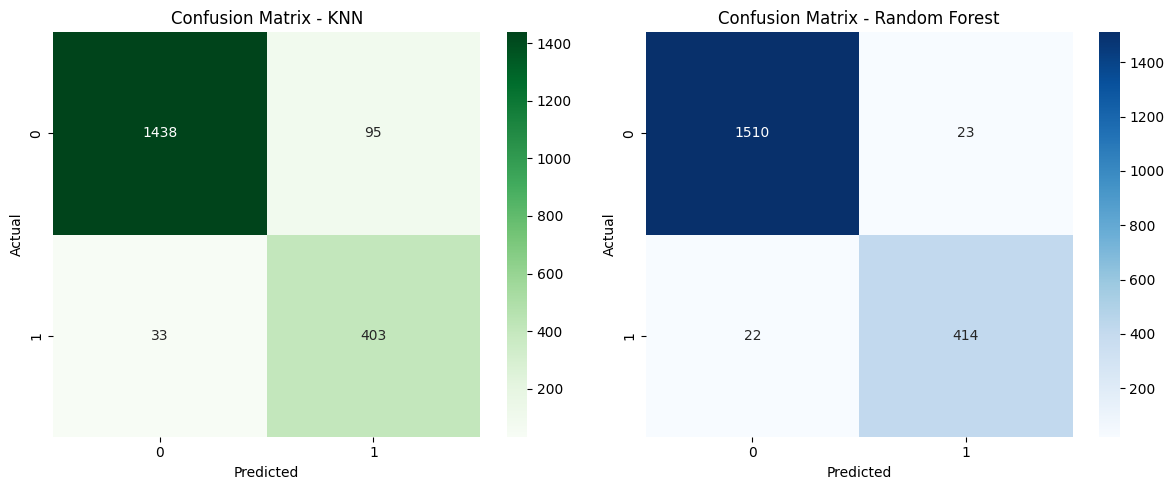

In [149]:
# Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', ax=axs[0])
axs[0].set_title("Confusion Matrix - KNN")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title("Confusion Matrix - Random Forest")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

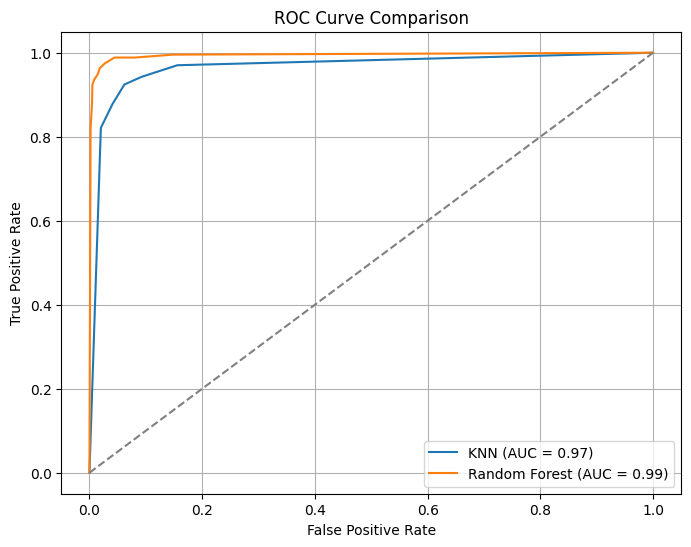

In [150]:
# ROC (Receiver Operating Characteristic)

from sklearn.metrics import roc_curve, auc

fpr_knn, tpr_knn, _ = roc_curve(y_test, knn.predict_proba(x_test_scaled)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(x_test_scaled)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc(fpr_knn, tpr_knn):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()